<a href="https://colab.research.google.com/github/jjone36/Groot/blob/master/Copy_of_94_cnn_NeuralStyler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
import tensorflow as tf
from keras.applications import vgg19

from keras.models import Model

Using TensorFlow backend.


## 1. Import the data

In [0]:
from google.colab import files
file = files.upload()

(-0.5, 959.5, 719.5, -0.5)

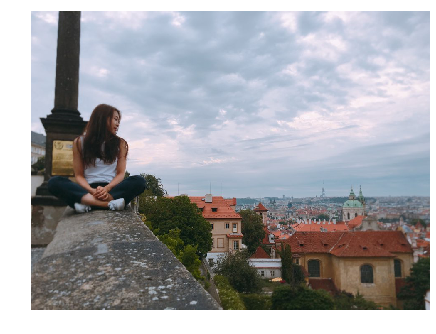

In [6]:
img_1 = plt.imread('/content/prague.jpg')
plt.imshow(img_1)
plt.axis('off')

(-0.5, 1029.5, 772.5, -0.5)

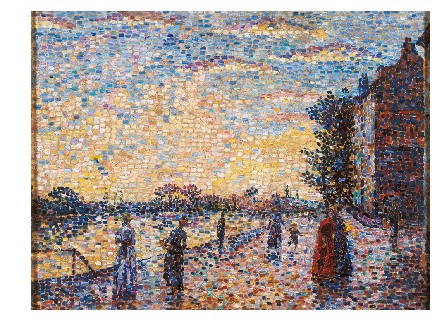

In [7]:
img_2 = plt.imread('/content/style.jpg')
plt.imshow(img_2)
plt.axis('off')

In [0]:
im_size = 512

content_path = '/content/prague.jpg'
style_path = '/content/style.jpg'

In [0]:
from PIL import Image
from tensorflow.python.keras.preprocessing import image as kp_image

In [0]:
def load_process(path):
  
  max_dim = 512
  img = Image.open(path)
  
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)

  return img

In [0]:
# def load_process(path):
  img = plt.imread(path)
  
  img = resize(img, (im_size, im_size, 3))
  img_array = np.asarray(img, dtype = 'float32')
  img_array = np.expand_dims(img_array, axis = 0)
  
  img_array[:, :, :, 0] -= 103.939
  img_array[:, :, :, 1] -= 116.779
  img_array[:, :, :, 2] -= 123.68
  img_array = img_array[:, :, :, ::-1]
  
  img = vgg19.preprocess_input(img_array)
  
  return img

In [0]:
content_img = load_process(content_path)
style_img = load_process(style_path)

In [0]:
def deprocess_img(img):
  img = img.reshape((im_size, im_size, 3))
  
  img = img[:, :, ::-1]
  img[:, :, 0] += 103.939
  img[:, :, 1] += 116.779
  img[:, :, 2] += 123.68
  
  img = np.clip(img, 0, 255).astype('uint8')
  
  return img

## 2. Modeling

In [0]:
vgg = vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

In [29]:
vgg.input

<tf.Tensor 'input_2:0' shape=(?, ?, ?, 3) dtype=float32>

In [30]:
vgg.output

<tf.Tensor 'block5_pool_1/MaxPool:0' shape=(?, ?, ?, 512) dtype=float32>

This is for making an empty space which is fittable for VGG19. We can think it like kind of the frame for the model.

In [31]:
layers_dic = dict([(i.name, i.output) for i in vgg.layers])
layers_dic

{'block1_conv1': <tf.Tensor 'block1_conv1_1/Relu:0' shape=(?, ?, ?, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_1/Relu:0' shape=(?, ?, ?, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_1/MaxPool:0' shape=(?, ?, ?, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_1/Relu:0' shape=(?, ?, ?, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_1/Relu:0' shape=(?, ?, ?, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_1/MaxPool:0' shape=(?, ?, ?, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_1/Relu:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_1/Relu:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_1/Relu:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4_1/Relu:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_1/MaxPool:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block4_conv1': <tf.

In [0]:
# Content layer for feature maps
content_layers = ['block5_conv2'] 

# Style layer for feature map
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

n_C_layers = len(content_layers)
n_S_layers = len(style_layers)

In [33]:
style_outputs = [layers_dic[i] for i in style_layers]
style_outputs

[<tf.Tensor 'block1_conv1_1/Relu:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_1/Relu:0' shape=(?, ?, ?, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1_1/Relu:0' shape=(?, ?, ?, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1_1/Relu:0' shape=(?, ?, ?, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1_1/Relu:0' shape=(?, ?, ?, 512) dtype=float32>]

We are going to make build a model with pretrained model VGG19. It's just like what we did with **`model(input, output)`**. But this time, the output will be the outcomes from these layers we defined above. The outcome from the content layer and the outcome from the style layers we selected. Later, this will be used for ~~

In [0]:
def get_model():
  
  vgg = vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  
  model = Model(vgg.input, model_outputs)
  
  return model

## 3. What is the feature map?

We made the empty spaces for the outcomes of the model. And from now on, we'll see the actual outcome that will be put into the frames that we made with `get_model()` above.

In [0]:
def get_feature(model, content_img, style_img):
  
  content_outputs = model(content_img)
  style_outputs = model(style_img)
  
  content_features = [layer[0] for layer in content_outputs[n_S_layers:]]
  style_features = [layer[0] for layer in style_outputs[:n_S_layers]]
  
  return content_features, style_features

## 3. Loss functions

In [0]:
# Content loss function
def content_loss(content, generated):
    J_content = tf.reduce_mean(tf.square(content, generated))
    return J_content

In [0]:
# Style loss function
def gram_matrix(A):
  height, width, channel = A.get_shape().to_list()
  A = tf.transpose(tf.reshape(A, [height*width, channel]))
  gram = tf.matmul(A, tf.transpose(A))
  return gram, height, width, channel 

# Style loss for a layer 
def layer_style_loss(style, generated):
  style_gram, height, width, channel = gram_matrix(style)
  generated_gram, _ = gram_matrix(generated)
  J_style_layer = tf.reduce_sum(tf.square(style_gram - generated_gram)) / (4 * (channel**2) * (height*width)**2)
  return J_style_layer

In [0]:
def compute_loss(model, style_weight, content_weight, gram_style_features, content_features):
  
  model_outputs = model(init_img)
  
  content_outputs_features = model_outputs[n_S_layers:]
  style_outputs_features = model_outputs[:n_S_layers]
  
  style_score = 0
  content_score = 0

  # Accumulate content losses from all layers 
  weight_c = 1.0 / float(n_C_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_c * content_loss(comb_content[0], target_content)
    
  # Accumulate style losses from all layers
  weight_s = 1.0 / float(n_S_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_s * layer_style_loss(comb_style[0], target_style) 
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  
  return loss, style_score, content_score

In [0]:
def compute_grads(cfg):
  
  with tf.GradientTape() as tape:
    all_loss = compute_loss(**cfg)
  
  grads = tape.gradient(all_loss[0], cfg['init_img'])     # loss of input image
  
  return grads, all_loss

In [0]:
# import IPython.display

def neural_styler(content_img, style_img, num_iter = 500, content_weight = 1e3, style_wieght = 1e-2):

    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    content_features, style_features = get_feature(model, content_img, style_img)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    init_image = tf.Variable(content_img, dtype = tf.float32)

    opt = tf.train.AdamOptimizer(learning_rate = 5)

    iter_count = 1
    best_loss, best_img = float('inf'), None    # initialization for the best outcomes

    cfg = {
        'model' : model,
        'style_weight' : style_weight,
        'content_weight' : content_weight,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
    imgs = []
    
    for i in range(num_iter):
        grads, all_loss = compute_grads(cfg)

        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_imgae, min_vals, max_vals)
        init_image.assign(clipped)

        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

    return best_img 

In [0]:
im_size = 512

content_path = '/content/prague.jpg'
style_path = '/content/style.jpg'

content_img = load_process(content_path)
style_img = load_process(style_path)

In [43]:
best_img = neural_styler(content_img, style_img)

ValueError: ignored

In [0]:
from PIL import Image
Image.formarray(best_img)